<a href="https://colab.research.google.com/github/KCemOzdemir/ImageNoiseReductionTraining/blob/main/noisereduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Öncelikle Datasetimizi yükleyelim
#Bu projede MNIST-Fashion data setini kullanacağız.

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()
print("x_train'deki maksimum değer", x_train[0].max())
print("x_train'deki minimum değer", x_train[0].min())

4423680/4422102 [==============================] - 0s 0us/step
x_train'deki maksimum değer 255
x_train'deki minimum değer 0


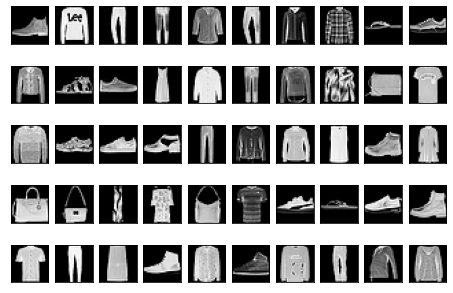

In [2]:
#Şimdi veri setimize bakalım

import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(tf.squeeze(x_test[a])) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1

In [3]:
#Şimdi datasetimizde aşağıdaki işlemleri yapıyoruz
# 1-) Öncelikle datasemizi normalize ediyoruz bu sayede 0-255 arası olan piksel dağılımı 0-1 arasına çekiyoruz
# 2-) Sonrasında fotoğrafımızı grayscale geçiriyoruz ve boyutlandırıyoruz (a,b,c) ----> (a,b,c,1) grayscle

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
#Amacımız görüntülerde gürültü azaltan bir model oluşturmak bunun için görüntülerimize gürültü ekleyeceğiz
#Burada ekleyeceğimiz gürültü çeşidi Gauissian White Noise 
#Bu gürültü normal dağılıma sahiptir ve 0-1 arasında değerler alır bu değeri artırmak için bir noise_factor tanımlayacağız
#Ve daha sonra tekrar datamızı 0-1 arasına set edeceğiz

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)


x_train_noisy  =  tf . clip_by_value ( x_train_noisy , clip_value_min = 0. , clip_value_max = 1. )
x_test_noisy  =  tf . clip_by_value ( x_test_noisy , clip_value_min = 0. , clip_value_max = 1. )


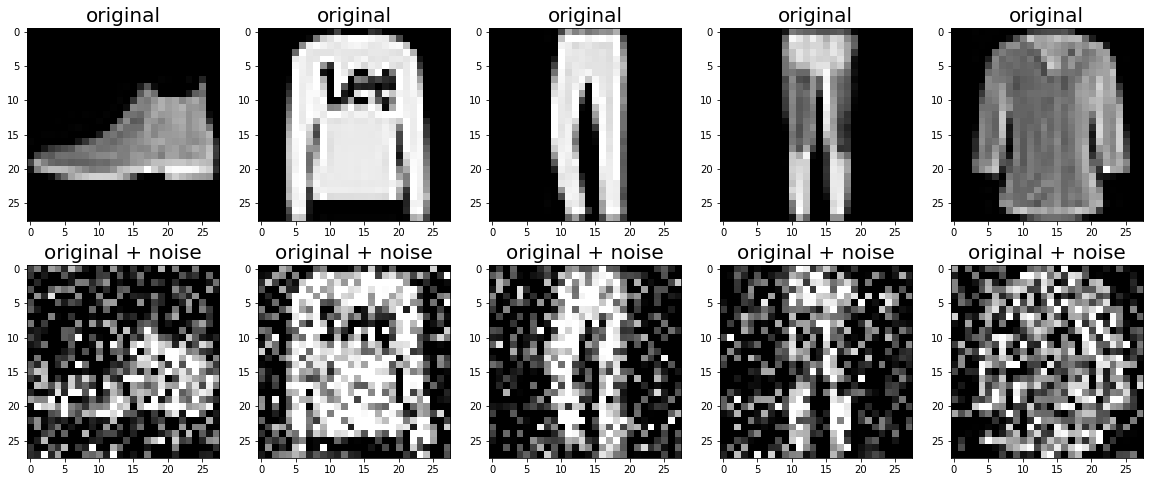

In [5]:
#Şimdi gürültü eklenmiş datalarımızın nasıl göründüğüne bakalım
n = 5
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test[i])) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
plt.show()

Şimdi Autoencoder (AE) nedir kısaca anlatmalıyım hem sizin hem benim öğrenmem için kısa öz bir şekilde anlatmam gerekirse AE girdiyi çıktıya benzetmeye çalışır ve denetimsiz bir öğrenme çeşididir. 2 ana kısma sahiptir birincisi encoder yani kodlayıcıdır ve ikincisi decoder yani kod çözücüdür. encoder kısmı giren bir veriyi belli bir forma sokmakla yükümlüdür encoderdan giriş alan decoder belli formdaki veriyi eski haline dönüştürmekle yükümlüdür. Convolutional AutoEncoder yapısı şekildeki gibidir [CAE](https://miro.medium.com/max/3000/1*VYH3i2-2CZ6Fyd7Bv9UHFw.png)

In [6]:
#Şimdi modelimizi geliştirelim


from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(28, 28, 1)), 
      Conv2D(16, (3,3), activation='relu', padding='same', strides=2), 
      Conv2D(8, (3,3), activation='relu', padding='same', strides=2)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

In [7]:
autoencoder = NoiseReducer()
autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
autoencoder.fit(x_train_noisy, x_train, epochs=15, shuffle=True, validation_data=(x_test_noisy,x_test))

Epoch 1/15
1875/1875 [==============================] - 12s 3ms/step - loss: 0.0435 - val_loss: 0.0171
Epoch 2/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 3/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 5/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 6/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 7/15
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 8/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 9/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.01

In [9]:
encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)

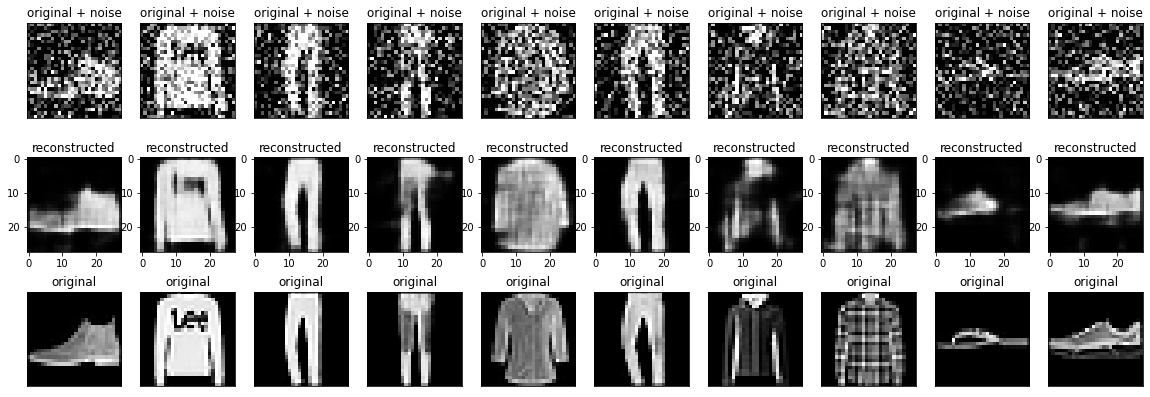

In [10]:
n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

plt.show()